In [1]:
from __future__ import print_function

from keras.preprocessing.image import load_img,save_img,img_to_array
from keras.applications import inception_resnet_v2,inception_v3
from keras import backend as K
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import scipy
import argparse

Using TensorFlow backend.


In [2]:
model = inception_resnet_v2.InceptionResNetV2(weights="imagenet",
                                include_top=False)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
batch_normalization_124 (BatchN (None, None, None, 1 576         conv2d_124[0][0]                 
__________________________________________________________________________________________________
activation_121 (Activation)     (None, None, None, 1 0           batch_normalization_121[0][0]    
__________________________________________________________________________________________________
activation_124 (Activation)     (None, None, None, 1 0           batch_normalization_124[0][0]    
__________________________________________________________________________________________________
block17_12_mixed (Concatenate)  (None, None, None, 3 0           activation_121[0][0]             
                                                                 activation_124[0][0]             
__________________________________________________________________________________________________
block17_12

In [158]:
parser = argparse.ArgumentParser(description="Deep Dreams with Keras.")
parser.add_argument("base_image_path",
                    metavar="base",
                    help="Path to the image to transform.")
parser.add_argument("result_prefix",
                    metavar="res_prefix",
                    help="Prefix for the saved results.")

args = parser.parse_args(args=["base_images\\IMG_0421.JPG","result\\nightmare"])
base_image_path = args.base_image_path
result_prefix = args.result_prefix

"""
    "features":{
        "mixed0":1.05,
        #"conv2d_22":0.1,
        #"conv2d_25":0.8,
        "mixed2":1.09,
        #"conv2d_28":0.05,
        "mixed3":1.07,
        "mixed4":2.,
        "mixed5":1.8,
        "mixed6":3.1,
        "mixed7":3.2,
        #"conv2d_42":0.6,
        #"conv2d_47":0.07,
        #"conv2d_43":0.09,
        "mixed8":1.2
    }"""

"""settings = {
    "features":{
        'conv2d_1': 0.4,
        'mixed1': 0.2,
        #'conv2d_22':0.01,
        'conv2d_28': 0.8,
        'batch_normalization_45': 1.,
        'mixed3': 0.5,
        'mixed4': 2.,
        #'mixed5': 1.5,
        #'mixed6': 1.3,
        #'mixed7': 1.3
    }
}"""

settings = {
    "features":{
        #'block35_1_mixed': 0.2,
        #'block35_2_mixed': 0.5,
        #'block35_3_mixed': 0.9,
        #'block35_4_mixed': 1.1,
        #'block35_5_mixed': 1.2,
        #'block35_6_mixed': 1.5,
        #'block35_7_mixed': 1.1,
        #'block35_8_mixed': 1.4,
        #'block35_1': 0.4,
        #'block35_2': 0.9,
        #'block35_3': 0.9,
        #'block35_4': 1.4,
        #'block35_5': 1.3,
        #'block35_6': 1.5,
        #'block35_7': 1.2,
        #'block35_8': 1.1
        #'batch_normalization_70': 1.0,
        'batch_normalization_71': 1.0,
        'batch_normalization_142': 1.0
        #'batch_normalization_74': 1.0,
        #'batch_normalization_77': 1.0,
        #'activation_82': 1.0
        #'conv2d_35': 0.9,
        
    }
}

In [159]:
def preprocess_image(image_path):
    img = load_img(image_path)
    img = img_to_array(img)
    #img = Image.open(image_path)
    limit_size = 1080
    """if img.width > limit_size and img.height > limit_size:
        max_length = max(img.size)
        resize_rate = max_length / limit_size
        print(resize_rate)
        img = img.resize((round(img.width / resize_rate),round(img.height / resize_rate)))

    img = np.array(img)"""
    if img.shape[0] > limit_size or img.shape[1] > limit_size:
        max_length = max(img.shape)
        resize_rate = limit_size / max_length
        factors = (float(resize_rate),
                  float(resize_rate),
                  1)
        print(factors)
        img = scipy.ndimage.zoom(img,factors,order=1)
        
    
    img = np.expand_dims(img,axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    
    if K.image_data_format() == "channels_first":
        x = x.reshape((3,x.shape[2],x.shape[3]))
        x = x.transpose((1,2,0))
    else:
        x = x.reshape((x.shape[1],x.shape[2],3))
        
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x,0,255).astype("uint8")
    return x

dream = model.input
layer_dict = dict([(layer.name,layer) for layer in model.layers])
loss = K.variable(0.)

for layer_name in settings["features"]:
    print(layer_name)
    if layer_name not in layer_dict:
        raise ValueError('Layer {} not found...'.format(layer_name))
    coeff = settings["features"][layer_name]
    x = layer_dict[layer_name].output
    scaling = K.prod(K.cast(K.shape(x),"float32"))
    
    if K.image_data_format() == "channels_first":
        loss += coeff * K.sum(K.square(x[:,:,2:-2,2:-2])) / scaling
    else:
        loss += coeff * K.sum(K.square(x[:,2:-2,2:-2,:])) / scaling

grads = K.gradients(loss,dream)[0]
grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())

outputs = [loss,grads]
fetch_loss_and_grads = K.function([dream],outputs)

batch_normalization_142
batch_normalization_71


In [5]:
K.set_learning_phase(0)

In [6]:
settings

{'features': {'block35_1': 0.4,
  'block35_1_mixed': 0.2,
  'block35_2': 0.9,
  'block35_2_mixed': 0.5,
  'block35_3': 0.9,
  'block35_3_mixed': 0.9,
  'block35_4': 1.4,
  'block35_4_mixed': 1.1,
  'block35_5': 1.3,
  'block35_5_mixed': 1.2,
  'block35_6': 1.5,
  'block35_6_mixed': 1.5,
  'block35_7_mixed': 1.1}}

In [6]:
def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_values = outs[0]
    grads_values = outs[1]
    return loss_values,grads_values

def resize_img(img,size):
    img = np.copy(img)
    if K.image_data_format() == "channels_first":
        factors = (1,1,
                  float(size[0]) / img.shape[2],
                  float(size[1]) / img.shape[3])
    else:
        factors = (1,
                  float(size[0]) / img.shape[1],
                  float(size[1]) / img.shape[2],
                  1)
    print(factors)
    return scipy.ndimage.zoom(img,factors,order=1)


def gradient_ascent(x,iterations,step,max_loss=None):
    for i in range(iterations):
        loss_values,grads_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_values > max_loss:
            break
        print("..Loss value at {0} : {1}".format(i,loss_values))
        x += step * grads_values
        
    return x

In [9]:
numoctave = 4
for i in range(1-2,numoctave-2):
    print(200 / (1.3 ** i))

260.0
200.0
153.84615384615384


target image --> base_images\IMG_0421.JPG
(0.7307171853856563, 0.7307171853856563, 1)
[(440, 587), (539, 719), (661, 881), (810, 1080)]
Part0
Processing image shape (440, 587)
(1, 0.5432098765432098, 0.5435185185185185, 1)
Part1
Processing image shape (440, 587)
(1, 0.5432098765432098, 0.5435185185185185, 1)
..Loss value at 0 : 3.1772122383117676
..Loss value at 1 : 3.358595132827759
..Loss value at 2 : 3.6837756633758545
..Loss value at 3 : 4.067534446716309
..Loss value at 4 : 4.493961334228516
..Loss value at 5 : 4.931695938110352
..Loss value at 6 : 5.393471717834473
..Loss value at 7 : 5.728722095489502
..Loss value at 8 : 6.295319557189941
..Loss value at 9 : 6.733524322509766
..Loss value at 10 : 7.25135612487793
..Loss value at 11 : 7.520205974578857
..Loss value at 12 : 8.183862686157227
..Loss value at 13 : 8.941946983337402
..Loss value at 14 : 9.182209968566895
..Loss value at 15 : 9.540922164916992
..Loss value at 16 : 10.198089599609375
..Loss value at 17 : 10.97597217559

..Loss value at 98 : 71.88687896728516
..Loss value at 99 : 73.04352569580078
(1, 1.225, 1.2248722316865417, 1)
(1, 0.6654320987654321, 0.6657407407407407, 1)
(1, 0.6654320987654321, 0.6657407407407407, 1)
Part3
Processing image shape (661, 881)
(1, 1.2263450834879406, 1.2253129346314326, 1)
..Loss value at 0 : 10.65603256225586
..Loss value at 1 : 17.06403350830078
..Loss value at 2 : 19.522907257080078
..Loss value at 3 : 21.538860321044922
..Loss value at 4 : 25.143245697021484
..Loss value at 5 : 26.42265510559082
..Loss value at 6 : 29.43283462524414
..Loss value at 7 : 30.474374771118164
..Loss value at 8 : 32.518707275390625
..Loss value at 9 : 32.411842346191406
..Loss value at 10 : 35.5632209777832
..Loss value at 11 : 36.19873046875
..Loss value at 12 : 38.33317184448242
..Loss value at 13 : 38.68941879272461
..Loss value at 14 : 40.575462341308594
..Loss value at 15 : 41.15894317626953
..Loss value at 16 : 42.85102844238281
..Loss value at 17 : 42.96834182739258
..Loss value

..Loss value at 97 : 82.43495178222656
..Loss value at 98 : 82.92585754394531
..Loss value at 99 : 83.12892150878906
(1, 1.2254160363086233, 1.2258796821793416, 1)
(1, 1.0, 1.0, 1)
(1, 1.0, 1.0, 1)


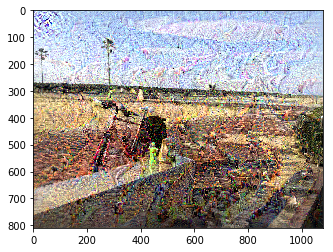

In [160]:
step = 0.01  # Gradient ascent step size
num_octave = 4  # Number of scales at which to run gradient ascent
octave_scale = 1.225  # Size ratio between scales
iterations = 100  # Number of ascent steps per scale
max_loss = 95.

print("target image --> {}".format(base_image_path))
img = preprocess_image(base_image_path)

if K.image_data_format() == "channels_first":
    original_shape = img.shape[2:]
else:
    original_shape = img.shape[1:3]

successive_shapes = [original_shape]
original_img = np.copy(img)
for i in range(1,num_octave):
    shape = tuple([int(dim / (octave_scale **i)) for dim in original_shape])
    successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]
print(successive_shapes)
original_img = np.copy(img)
print("Part0")
print("Processing image shape",shape)
shrunk_original_img = resize_img(img,successive_shapes[0])


for j,shape in enumerate(successive_shapes):
    print("Part{}".format(j+1))
    print("Processing image shape",shape)
    img = resize_img(img,shape)
    img = gradient_ascent(img,
                         iterations=iterations,
                         step=step,
                         max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img,shape)
    same_size_original = resize_img(original_img,shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    
    img += lost_detail
    shrunk_original_img = resize_img(original_img,shape)
    
nightmare = deprocess_image(np.copy(img))
save_img("{}.jpg".format(result_prefix),nightmare)
plt.imshow(nightmare)

In [40]:
successive_shapes[0]

(543, 407)

In [19]:
successive_shapes

[(353, 535), (356, 540), (359, 545), (363, 550), (366, 555), (396, 600)]

In [10]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4940784226305727432]